## A Few Notes For Those Observing This Work

* It is good to run these sections in order, as some library imports and variables are used in subsequent sections
* There is some commented out code I used for debugging in many places.  I found it simpler to debug printing out what actually was present than with wrapping asserts around these things.  I left that code in place so you can see where these trouble points generally were.
* There are some parts of the code that are not run (commented out) because the did not help the model as it stands and/or were really slow to run.  For example, adding additional training data by messing with the brightness and contrast.
*  There are undoubtably better models, and there are undoubtably people with better knowledge of the optimizers for TensorFlow, and undoubtably peopel with better intuition about the model's hyperparameters.  I chose a direction to pursue and wanted to see it through, spending time making it perform well.  If there was indefinite time on the assignment I would have explored more models and compared them.
* The code is real sloppy.  Again, if there was indefinite time on the assignment, it would be great to make it much cleaner.  I guess the excuse is it is explorative.
* There are TONS of additional things I would like to do to improve this, like try augmenting grayscale with some reduced space color figure (rather than full RGB), redo it using convolutional networks, redo it using inception modules, etc.  

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data

import pickle


training_file = 'train.p'
testing_file  = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
features_train = train['features']
labels_train   = train['labels']
features_test  = test['features']
labels_test    = test['labels']



# Just a type test...
print(type(features_train))

# Test of what the labels look like
print(labels_train[1000])

<class 'numpy.ndarray'>
1


In [2]:
# We can see that we will want to convert the labels to a sparse one-hot encoding
import numpy as np
from sklearn.preprocessing import LabelBinarizer

train_encoder = LabelBinarizer()
train_encoder.fit(labels_train)

# To confirm what the labels were before...
print(labels_train)

labels_train = train_encoder.transform(labels_train).astype(np.float32)

test_encoder = LabelBinarizer()
test_encoder.fit(labels_test)

labels_test  = test_encoder.transform(labels_test).astype(np.float32)


# Just to make sure they are transformed as expected
print(labels_train)
print(labels_train[0])
print(labels_train[-1])



[ 0  0  0 ..., 42 42 42]
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.]


In [3]:
### To start off let's do a basic data summary.
import numpy as np

# This is revisited with different names later when we are setting up the NN 

n_train     = len(features_train)
n_test      = len(features_test)
image_shape = features_train[0].shape    # Will be flattened later
n_classes   = labels_train[0].size       # Any particular one-hot label will do


print("Number of training examples = ", n_train)
print("Number of testing examples = ", n_test)
print("Image data shape = ", image_shape)
print("Number of classes = ", n_classes)

Number of training examples =  39209
Number of testing examples =  12630
Image data shape =  (32, 32, 3)
Number of classes =  43


Training images


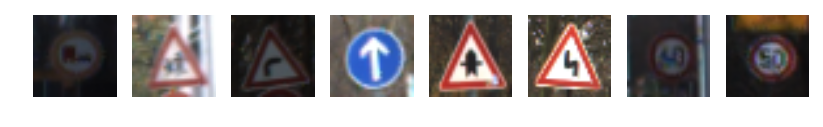

Test images


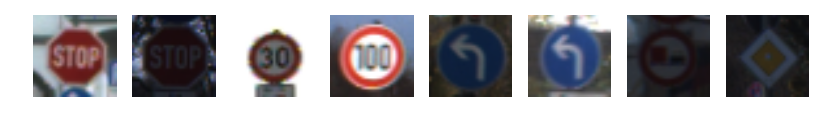

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# Show a few random images out of the list of training and test features
print("Training images")
fig = plt.figure(figsize = (10,10))

for i in range(1,9):
    fig.add_subplot(1,8,i)
    rnd_image = random.choice(features_train)
    plt.imshow(rnd_image)
    plt.axis('off')
    
plt.show()


print("Test images")
fig = plt.figure(figsize = (10,10))

for i in range(1,9):
    fig.add_subplot(1,8,i)
    rnd_image = random.choice(features_train)
    plt.imshow(rnd_image)
    plt.axis('off')
    
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Idea is that we are just going to scale the 0 - 255 integer values into [-1, 1] floating point
# Reason for this is numeric stability

# Since we are going to collapse the channels anway, we just build new ndarrays with it collapsed here


from tqdm import tqdm

# This direct method is rather slow
#def normalize_image(image):
#    result = []
#    for i in range(len(image)):
#        for j in range(len(image[i])):
#            for k in range(len(image[i][j])):
#                result.append((image[i][j][k] - 128.0) / 128.0)
#    return np.array(result, np.float32)            
 
    
# numpy overload scaling to [-0.5, 0.5] seems to work best
def normalize_image(image):
    return ((image - 128.0) / 256.0).flatten()

    
def normalize_pickle(pickle):
    result = []
    pickle_pbar = tqdm(range(len(pickle)), unit='images')
    for image in pickle_pbar:
        result.append(normalize_image(pickle[image]))
    return np.array(result, np.float32)



# We will actually invoke this normalization after generating additional data since we would want to look
# at the additional data to make sure it is satisfactory in appearance first


### Question 1 

_Describe the techniques used to preprocess the data._


The data set is pre-scaled to 32 x 32 RGB images.  We do not want to do a lot of pre-processing with the images.  In looking at them (see above), there is a wide range of contrasts in the image set.  Color is a dominant property as well as shape, contrast, etc.  Since there is no apparent advantage in transforming these quantities (generating new versions of the existing training data is addressed in the next sections -- I am referring only to transforms on each of the original frames here), the only thing that would be helpful to do is scale the image values to a normalized deviation around a zero mean.  So we make that single transformation.  

We want to help the feed forward neural network do the best job possible and with the least computational resources, so if we could increase contrast to help with feature classification, or change color space, or whatever else, these could improve the efficiency of the system.  However, most of these ideas are linear functions of the data, which is what the network is already adept at handling.  The only thing we need to take especial care with, especially for large problems, is numerical stability.  Hence limiting our pre-processing to scaling to a normalized, zero-biased interval.  What I found to work best was a [-0.5, 0.5] interval.

In [6]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

import matplotlib.colors as mcol


# Having to do with creating new images based on HSV operations

def convert_to_hsv(rgb):
    return mcol.rgb_to_hsv(rgb)
    
def convert_to_rgb(hsv):
    return mcol.hsv_to_rgb(hsv)

def transform_hsv(hsv, amount):
    return hsv + amount
    
def adjust_hsv(rgb, amount):
    hsv = convert_to_hsv(rgb)
    hsv[2] = np.array([transform_hsv(x, amount) for x in hsv[2]])
    return convert_to_rgb(hsv)
    
def create_converted_image(source, index):
    image = source[index]
    np.append(source, adjust_hsv(image, 10))
    np.append(source, adjust_hsv(image, -10))
    
    
# Basic function tests
#create_converted_image(features_train, 1)
    
    
#print('Starting with ' + str(len(features_train)) + ' images.')    

#images_pbar = tqdm(range(len(features_train)), unit='images')
#for image in images_pbar:
#    create_converted_image(features_train, image)

#print('Done creating HSV images')
#print('Ending with ' + str(len(features_train)) + ' images.')


# NOTE!!!
# This image generation mechanism is really slow, that is why the part that runs it is commented out

In [7]:
# Having to do with creating new images based on contrast operations

from PIL import ImageEnhance
from PIL import Image


def adjust_contrast(image, amount):
    contrast = ImageEnhance.Contrast(image)
    return np.array(contrast.enhance(amount))

def create_adjusted_image(source, index):
    image = Image.fromarray(source[index])
    np.append(source, adjust_contrast(image, 1))
    np.append(source, adjust_contrast(image, 2))


# Basic function tests
#create_adjusted_image(features_train, 1)


#print('Starting with ' + str(len(features_train)) + ' images.') 

#images_pbar = tqdm(range(len(features_train)), unit='images')
#for image in images_pbar:
#    create_adjusted_image(features_train, image)
    
#print ('Done creating contrast images')
#print('Starting with ' + str(len(features_train)) + ' images.') 


# NOTE!!!
# This image generation mechanism is really slow, that is why the part that runs it is commented out

## Note on the image manipulations

This worked fairly poorly.  Very slow to run, and the order of difference they made was overshadowed by other factors.  I opted not to use this approach, but wanted to leave it in here since I think it is a nice approach in trying to dynamically generate a wider feature space to prevent problems with generalizing.


Training images


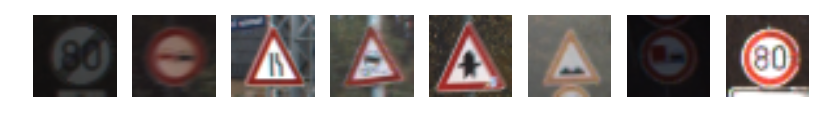

Test images


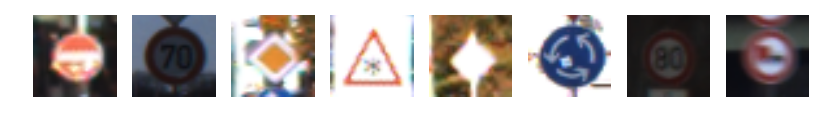

In [8]:
# Now we want to check that the images still look reasonable
# After we normalize the images (next step), they will not be as interpretable visually

# Show a few random images out of the list of training features

print("Training images")
fig = plt.figure(figsize = (10,10))

for i in range(1,9):
    fig.add_subplot(1,8,i)
    rnd_image = random.choice(features_train)
    plt.imshow(rnd_image)
    plt.axis('off')
    
plt.show()


print("Test images")
fig = plt.figure(figsize = (10,10))

for i in range(1,9):
    fig.add_subplot(1,8,i)
    rnd_image = random.choice(features_test)
    plt.imshow(rnd_image)
    plt.axis('off')
    
plt.show()

In [9]:
# Now we will normalize the images as noted previously

features_train = normalize_pickle(features_train)
features_test = normalize_pickle(features_test)

# For sanity we print feature_train to verify it has been collapsed and is in the expected floating point range

print(features_train)


100%|██████████| 12630/12630 [00:00<00:00, 48157.93images/s]


[[-0.20703125 -0.1953125  -0.1875     ..., -0.1484375  -0.12109375
  -0.15234375]
 [-0.23046875 -0.21484375 -0.21484375 ..., -0.10546875 -0.09375    -0.125     ]
 [-0.21875    -0.21875    -0.21875    ..., -0.12890625 -0.12109375
  -0.14453125]
 ..., 
 [-0.4609375  -0.4609375  -0.453125   ..., -0.45703125 -0.45703125
  -0.44921875]
 [-0.44921875 -0.453125   -0.44140625 ..., -0.45703125 -0.4609375
  -0.45703125]
 [-0.45703125 -0.4609375  -0.453125   ..., -0.4609375  -0.46484375
  -0.45703125]]


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_


The training and testing data was simply loaded from file.  The files were provided.  There is some code to display an image that was put in simply to validate that the images appeared to load as expected.

I did opt to look into generating additional data.  In this case, it was contrast and brightness bracketing. The reason for this is because the for any given image there are many variations that could be experienced in real life.  When we train the network, it will have a propensity to training to the examples it is shown.  In order to facilitate generalization, the span of the feature space can be artificially increased by generating related but distinct features.  The way that I did this was by varying the brightness and contrast.  While rotation and scale would be good as well, I did not do that because there would be time spent messing around with borders and resizing that could be better applied to other aspects of the problem.

I found that the use of these routines for generating additional training data was not very useful.  First, using the methods seen above, it added significant time to the training before the network model was even defined.  Second, since the fully connected feed forward network that I opted to use has the biggest problems with positional invariance, these methods were not achieving good results.  Since I was keeping color information by flattening the full RGB into the features, minor variations on color were not helpful in practice.  The original training set has quite a lot of variation in it of this nature already.  

When these were attempted, each of the variation routines produced two new images for each original image.  These were done back to back, so each original image actually generated nine new images.  This took the input features space from 
39,209 training cases to 352,881.  Since this procedure itself was quite slow and did not produce notably better results, I quickly stopped using it.  The code and the discussion is left here since it was one area that was tried.

It likely would have been more prudent to generate additional training images that could help overcome some of the problems with a feed forward network's problem with positional invariance.  That is, affine transformations. I did not start out doing this because of the challenge of rotations and some scaling leaving areas of the image undefined.  These would not be realistic test cases and I felt that I would miss some of the larger picture of the project by dwelling on some of these details.

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


import tensorflow as tf
import math



# Define some hyperparameters

eta     = 0.1
dropout = 0.5
deviation = 0.25

# Handy to know how many total images

total_training_images = len(features_train)



# Define the number of class items

image_size     = 32 * 32 * 3
labels_count   = labels_train[0].size



# For giggles, let's make the hidden layers a geometric size progression...

ratio = image_size / labels_count
scale_factor = pow(ratio, 0.333)

#hidden1_count = int(image_size / scale_factor)
#hidden2_count = int(hidden1_count / scale_factor)

hidden1_count = 200
hidden2_count = 100


# Print this stuff just to know
print('Teaining images to process: ' + str(total_training_images))
print('Features (image size): ' + str(image_size))
print('Hidden1 Size: ' + str(hidden1_count))
print('Hidden2 Size: ' + str(hidden2_count))
print('Unique labels (label one-hot dimension): ' + str(labels_count))



# Our features have already be arranged into normalized vectors of length 32 x 32 x 3
# The labels are a vector that is the size of the number of labels

# None will end up being the batch size later on

features = tf.placeholder(tf.float32, [None, image_size])
labels   = tf.placeholder(tf.float32, [None, labels_count])

dropout_ph = tf.placeholder(tf.float32)


# Define some weights and biases spanning all layers so we can index them easily to define network

weights = {
    'hidden1': tf.Variable(tf.truncated_normal([image_size, hidden1_count],stddev = deviation)), 
    'hidden2': tf.Variable(tf.truncated_normal([hidden1_count, hidden2_count], stddev = deviation)),
    'out'    : tf.Variable(tf.truncated_normal([hidden2_count, labels_count], stddev = deviation))
}

biases = {
    'hidden1': tf.Variable(tf.zeros([hidden1_count])), 
    'hidden2': tf.Variable(tf.zeros([hidden2_count])),
    'out'    : tf.Variable(tf.zeros([labels_count]))
}


# Define the actual layer maths

layer_1    = tf.matmul(features, weights['hidden1']) + biases['hidden1']
layer_1_r  = tf.nn.tanh(layer_1)
#layer_1_r  = tf.nn.relu6(layer_1)
layer_1_d  = tf.nn.dropout(layer_1_r, dropout_ph)

layer_2    = tf.matmul(layer_1_d, weights['hidden2']) + biases['hidden2']
layer_2_r  = tf.nn.tanh(layer_2)
#layer_2_r  = tf.nn.relu6(layer_2)
layer_2_d  = tf.nn.dropout(layer_2_r, dropout_ph)

logits     = tf.matmul(layer_2_d, weights['out']) + biases['out']

#logits = tf.Print(logits, [logits], 'Logits: '
                 
                 
# Define the cost and optimizer

# This isn't as good as it leaves one to having to explicitly deal with edge cases
# such as argument to log being near zero
#prediction = tf.nn.softmax(logits)
#cross_ent  = -1.0 * tf.reduce_sum(labels * tf.log(prediction), reduction_indices = 1)
#cost       = tf.reduce_mean(cross_ent)

# The built-in softmax cross entropy is able to address some extra stability issues 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, labels)
cost          = tf.reduce_mean(cross_entropy)
optimizer     = tf.train.GradientDescentOptimizer(eta).minimize(cost)



# Define accuracy for tests
# If the selected outcomes are the same (e.g. argmax indicates same label)
# then cast bool to float32 and compute the mean 
# 1.0 is a good score, 0.0 is a bad score

correct_bool  = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
correct_float = tf.cast(correct_bool, tf.float32)
accuracy      = tf.reduce_mean(correct_float)


Teaining images to process: 39209
Features (image size): 3072
Hidden1 Size: 200
Hidden2 Size: 100
Unique labels (label one-hot dimension): 43


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


I have been interested in exploring the depth and number of hidden layers in a conventional neural network for this assignment.  It may well be that there are more efficient convolutional networks for this image data.  It is unclear to me how large the hidden layers should be (number of neurons per layer).  It did seem that in keeping with the notion that 1) more layers outperforms wider layers, and 2) there may not be sufficient separation from a composed linear mapping with less than two hidden layers, that it would be reasonable to set the number of hidden layers to at least two and to determine the number of neurons in each layer as a geometrical mean progressing from the number of input neurons (number of total image pixels times channels) and the output space (one-hot type vector with length the same as the number of distinct solutions in the image set). 

The geometrical interpolation was the starting point.  It proved very slow to train (approx. 1400 hidden neurons) and seemed to account for more features than the feature space actually had.  I say this because of intuition looking at the performance while testing against the test set.  It climbed in accuracy very slowly but consistently.  I couldn't tolerate the training speed, so I opted to retain the funneling approach of monotonic decrease in number of nuerons per layer, but to reduce the number.  I arrived at 200 and 100 as a point where I could get a balance of training time and accuracy.  It seemed that this complexity in the hidden layers fit the problem better.

The design of network always had the same number of features and labels.  I selected to use full RGB features, so the number of features was 32 x 32 x 3.  The reason I selected to use full RGB was because it is visually clear that there is information in the color.  If you consider the problem as a decision tree, color could be a node from which very different results would branch.  Clearly there is far more information than necassary retaining the three color channels, and of course there is a significant performance penalty in using a network with that many features.  But I wanted to see what happened with this approach, so I stuck with it.  I just used the flatten() method to flatten the images.  This simply collapses them consistently from 32 x 32 x 3 three dimensional representation to a 3072 single dimensional representation.  Clearly there were 43 labels.

Having selected a feed forward network with fully connected layers, I was aware that accuracy in practice may be problematic because of the characteristics of this type of network with respect to localization of features.  That is, slight translations could have fairly significant effects on the predicted label once trained.  I am fully aware of the limitations.

Based on the reasoning about the number of layers mentioned in the first paragraph, I always used just the two hidden layers.  As mentioned, I started with the number of neurons being geometrically scaled between the number of features and labels (739 and 178 neurons respectively).  This appeared in practice, as indicated by looking at the rate of accuracy improvement as a function of training, to be suboptimal, meaning very slow to train and seemingly high number of neurons for the number of labels and the complexity of the features.  Using these numbers of hidden layer inputs as a starting point, I gradually diminished them to the numbers seen in the code, namely 200 and 100 neurons.  This seemed to be a good number that fit the problem well and also trained more quickly.

The architecture that ended up used in the final model was a two hidden layer feed forward network with a single dimensional feature vector of size 3072, two hidden layers with 200 and 100 neurons, respectively, using 50% dropout and hyperbolic tangent for the activation function.  The logits had softmax applied and the cost was computed using cross entropy.  The cost function used was the built-in softmax_cross_entropy_with_logits() method that accounts for edge cases such as very small arguments to log().  Gradient descent was used with a constant learning constant, minimizing the cost.  


In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.



# Hyperparameters

epochs     = 2500
batch_size = 500

# After how many batches we check against the test data set
test_rate  = 500


# So we know while looking at results
batches = int(math.ceil(total_training_images / batch_size))

print('Mini-batch size: ' + str(batch_size))
print('Number of batches per epoch: ' + str(batches))


# Metric initialization (to graph later)
test_accuracy_list  = []
cost_list           = []
batch_list          = []
batch_counter       = 0


# Testing dictionary 
testing_dict = {features: features_test, labels: labels_test, dropout_ph: dropout}



# Initialize variables and set up the session, retaining for later use
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)
    
    
for epoch in range(epochs):

    batch_bar = tqdm(range(batches), desc = 'Epoch {:>2}/{}'.format(epoch, epochs), unit='batches')

    for i in batch_bar:

        batch_start = batch_size * i
        #print(batch_start)
        
        batch_features = features_train[batch_start : (batch_start + batch_size)]
        batch_labels   = labels_train[batch_start : (batch_start + batch_size)]
        
        training_dict = {features: batch_features, labels: batch_labels, dropout_ph: dropout}
        c, _ = sess.run([cost, optimizer], feed_dict = training_dict)
        

        if not batch_counter % test_rate: 

            test_accuracy = sess.run(accuracy, feed_dict = testing_dict)
            test_accuracy_list.append(test_accuracy)
            cost_list.append(c)

            batch_list.append(batch_counter / test_rate)
            print(c)
            
        batch_counter += 1
        
        
            
# Print the last test accuracy metric            
print('Test set accuracy: ' + str(test_accuracy_list[-1]))


# Plotting it can help identify trends to help select hyperparameters
plt.plot(batch_list, test_accuracy_list, 'r', label='Testing Accuracy')
#plt.plot(batch_list, cost_list, 'g', label='Cost')
plt.legend(loc = 4)
plt.show()


Due to the amount of logging from tqdm, I have removed the actual output and replaced it with the plot only.

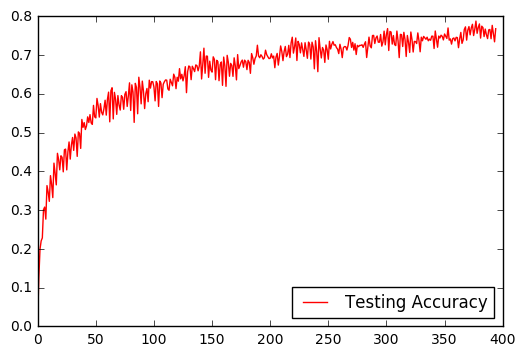

In [13]:
from IPython.display import Image
Image("images/training.png")

## Note on results

Not great accuracy.  I wanted to demonstrate what I have done with this problem and what I have learned.  That is also why there is a fair amount of commented out code.  I will duplicate this assignment using convolutional networks and would like to work on inception modules as well.  Seems more important to learn about it than dwell on less than ideal accuracy.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


It is pretty clear from the code how it was done.  The optimizer was gradient descent using the softmax cross entropy with one-hot encoded labels.  That seems to be a pretty standard cost model, and one that is computationally efficient to compute.  It is important to note the use of softmax_cross_entropy_with_logits, as this accommodates some ill-conditioning with log that otherwise can wreck havoc on the training.  The original data set was broken up into batches based on the "batch_size" hyperparameter.  This was later updated to include dropout.

This batch question has some nuanced answers.  Updates are made based on the cost from the batch, so if it is too large you may have trouble training, mainly because the gradient, being across the whole batch, can be rather large and tend to not find the local extrema.  On the other hand, full model updates every sample, while generally held to converge better in a sense, is extremely time consuming.  The figure for batch size I used seemed to give good and consistent results.  I suspect the larger batch size contributes to the volatility of the accuracy graph.  This may be able to be compensated by reducing the learning rate while it is training or simply using a smaller batch size and accepting a longer training time.

There are elso epochs, which of course are passes through the entire training set.  So we iterate over that range.  This of course simply exposes the network to the training data multiple times, which has an interplay with the learning constant eta and other hyperparameters in terms of training the network.  I found that I could use more epochs with the smaller network and get better results.  

Once the network was trained, we need to compute fitness metrics against the known testing data.  Without this information we can't determine how to adjust the hyperparameters to better values.  Indeed, it is useful to compute this every so often while it is training so that we can divine information about where it might start overtraining and loosing generality as a solution.  This got done based on the parameter visible in the code, and organized for plotting so that we could see a trend.  This seemed very important for trying to understand how to make improvements in training, as hyperparameters have a fairly large and complex space themselves, and we need as much information as we can get in order to be able to intelligently determine how to best train the network.

One problem that I had was undertraining the network.  I suppose this is because my machine takes forever and I was impatient.  It was quite a stumbling block for a while, as I was sure there was some other error that I was missing.  Looking at the accuracy over short training intervals appears fairly random with some periodicity related to the epochs.  It was not clear at first if it was some error having to do with stability generating the random look of it, so I wasted a lot of time messing around with that.  However, it was interesting trying different activation functions, different randomization at the beginning, different normalization, etc.  Below are some examples of what I tried.



### Progression of training 

This is a list of the variants on the training that I did:

* [-1, 1] normalization, two hidden layers, no dropout, default initialization std dev, relu
* [-1, 1] normalization, two hidden layers, 50% dropout, default initialization std dev, relu
* [0,1] normalization, two hidden layers, 50% dropout, default initialization std dev, relu
* [0,1] normalization, two hidden layers, 50% dropout, customized initialization std dev, relu
* [-0.5, 0.5] normalization, two hidden layers, 50% dropout, default initialization std dev, relu6
* [-0.5, 0.5] normalization, two hidden layers, 50% dropout, default initialization std dev, tanh
* Wide range of batch size, number of epochs, learning constant, neurons per hidden layer
* Variations on the loss / cost functions -- this was to explore small-value conditioning issues
* Variants on activation function (bounded relu, tanh)


### Question 5


_What approach did you take in coming up with a solution to this problem?_


I wanted to use a conventional multiple hidden layer network.  Why?  No particular reason, just have never trained one with image classification data before.  It is easier to understand some of the behaviors since the neurons are more similar than the convolutional networks.  It was a good place to play with the hyperparameters.  

I knew from a stability standpoint that I wanted to normalize the input.  Turned out that [-0.5, 0.5] worked best with the hyperparameters and other factors for this problem.  The cross entropy can have stability problems for small values, and TensorFlow has a nice solution that handles the edge cases, so I used that.  Training individual features per epoch is extremely slow, so it uses batches, the size of which became a hyperparameter.  I didn't want to do too many at a time for risk of not being able to stably find extrema, which I believe is related to the volatility in the accuracy graph.  On a specified period I computed the accuracy against the entire test set and saved that to plot.  

I didn't know how many neurons would be best, but did know that I wanted to gradually reduce the space from spanning the features to spanning the labels.  So I used a geometric interpolation across two hidden layers as a starting point.  My instinct made me feel this was too much complexity, so I ultimately reduced the number of neurons per layer.

There were some problems that I ran into with regard to undertraining, and because of misidentifying the cause, I ended up playing around a lot with dropout, activation functions, etc.  Despite the rationale not being sound for getting involved in that, it was quite instructive regarding choices for these, and this changed what I did with my model. Originally I used rectified linear activation functions, but found that the loss was systematically lower with the tanh activation function.  Even the constrainted relu6 option did not perform as well.  I found that 50% dropout worked better than lower amounts of dropout.  I suppose this indicates that the lower dropout probably was thrashing with overtraining and compensation later for it.  I highly doubt I found the sweet spot since the space of hyperparameters and things that can be adjusted is quite large, but I did make some incremental improvements in the performance.

I was never sure quite what to do about the issue of color.  Obviously I am computing on three times as much data as a grayscale image.  Obviously there is not really all that much information gained in the color.  I know that as a human I can use a gross notion of color to reduce the space of possible classifications in the decision tree sense.  I am not doing this based on RGB values.  It would seem that a better thing would be to compute a featue that is an average hue value of the image, or a subsampled variant of that, and be able to augment the grayscale image with this.  The right input data is important to help the network as well as the specifics of training it.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

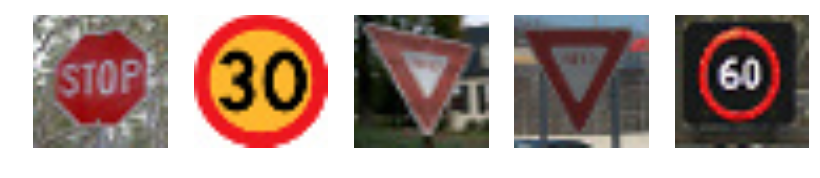

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


def load_image(file_number):
    return mpimg.imread('test_images/test' + str(file_number) + '.jpg')


fig = plt.figure(figsize = (10,10))

for i in range(1,6):
    fig.add_subplot(1,5,i)
    plt.imshow(load_image(i))
    plt.axis('off')
    
plt.show()


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



The above images are my selected images.  

Three of them are American signs, and none of these are especially good specimens (though in looking at the training and test sets, most of them are not either).  I would think that the rotation and focus/blur issues would potentially make classification difficult.  

However, two of them are dead on shots, very good quality images that are quite distinct.  Both have a somewhat different color scheme, which is important since I am used full RGB for the network.  Given the quality of a number of the training images, and the fact that the "30" and "60" signs above are colored somewhat differently, it may be the case that these are the ones that would be hardest to classify based on the training.

In [23]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

import numpy as np
from sklearn.preprocessing import LabelBinarizer

last_encoder = LabelBinarizer()
last_encoder.fit(labels_train)


# Define solutions
# I just manually looked these up from signnames.csv based on the images above
solutions_packed = [14,1,13,13,3]
solutions_onehot = last_encoder.transform(solutions_packed).astype(np.float32)

# Just to make sure they are transformed as expected
#print(solutions_onehot)


# Run tests over the previously plotted images
# The "accuracy" metric as defined previously is apparently not very good 
# here since it generates a misleading boolean output
# This is probably to do with significant digits and rounding, and the next
# section having to do with ranking the results is more meaningful
for i in range(1,6):
    image = load_image(i)
    image = normalize_image(image)
    test_dict = {features: [image], labels: [solutions_onehot[i-1]], dropout_ph: dropout}
    test_accuracy = sess.run(accuracy, feed_dict = test_dict)
    print('Image ' + str(i) + ': ' + str(test_accuracy))
    


Image 1: 1.0
Image 2: 0.0
Image 3: 1.0
Image 4: 1.0
Image 5: 1.0


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


This is somewhat hard to say unless a large number of test cases are examined.  There are two possible answers to this question.  First, how did it perform on the known test cases, something we already know.  In this case, the known test cases were similar to the training data in the sense that they are from the same pool of images.  That is to say, the signs may be from different angles and in different conditions, but they are not radically different signs.  In this case we know that the accuracy is as indicated in prior answers and indicated by the graph of the accuracy against the test set as a function of the training iterations.  Second, how does the trained network compare with the new sign images that were acquired outside of the provided testing set.  In this case, the signs are from different origin.  while we can find amusement in how well a particular sign in this small test set compares when classified by our network, the real answer is how the accuracy fairs when it is generalized to a large number of images.  I don't have a good answer on this as I have not generated a significant number of test case from which to compute a solid accuracy metric.  What can be said is that there are clearly features of some of the new signs that are able to be detected by the network that was trained and validated with the provided training and test set.

In [30]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# New accuracy function
softmax = tf.nn.top_k(tf.nn.softmax(logits), 5)

# Run through the new test images reporting the indices of the top 5 softmax values
# We can then look these up and see what the actual signs it thought it detected were
for i in range(1,6):
    image = load_image(i)
    image = normalize_image(image)
    test_dict = {features: [image], labels: [solutions_onehot[i-1]], dropout_ph: dropout}
    sm_top5 = sess.run(softmax, feed_dict = test_dict)
    print('Image ' + str(i) + ': ' + str(sm_top5.indices))
    print('Image ' + str(i) + ': ' + str(sm_top5.values))
    print("\n")
    


Image 1: [[14 17  5  4  3]]
Image 1: [[  9.99839067e-01   1.34199858e-04   1.29587033e-05   1.02011481e-05
    1.89910224e-06]]


Image 2: [[ 6  5  3  1 28]]
Image 2: [[ 0.58598024  0.20384847  0.16722845  0.00978439  0.00870116]]


Image 3: [[13 15  5  3  4]]
Image 3: [[  9.98519480e-01   6.98530581e-04   6.25525543e-04   7.35448630e-05
    1.78798418e-05]]


Image 4: [[13 15  9 28  5]]
Image 4: [[  9.27002847e-01   6.93809465e-02   2.75394414e-03   2.11250299e-04
    1.51755448e-04]]


Image 5: [[ 3 17 34  5  9]]
Image 5: [[ 0.82430702  0.11035208  0.04013501  0.01153644  0.00524229]]




### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


As indicated by the graph of accuracy as a function of training, the gross accuracy against the provided test cases could be better.  However, one would expect somewhat similar performance against new data.  And it did meet this expectation quite well.  

The way this was determined was for each of the five selected images that were obtained completely separately from the training and test sets, the output of the softmax of the logits after running the new feature forward through the network were sorted greatest to least.  This amounts to the ranked list of probabilities for each of the labels, most likely first.  Only the first five of these rankings were kept, which is what the arrays above this question represent.

In four of the five tests, the image that was the best match (based on the dictionary mapping labels to sign type provided) was the most probably result.  Regarding the relative likelihood of the top five results, in the cases have to do with the stop and yield signs (images 14 and 13, respectively), there is very good prediction accuracy as indicated by the magnitude of the top-ranked softmax value (in these cases, they are in the mid to high 90% range).  This is not too surprising because the test sign images are fairly similar to examples in the training set.  The "60" sign (image 3), fairs well also, though only has 82% probabily resulting from the softmax function.

In the fifth case, the correct label was in the top five most probably but not the most probable.  In this fifth case, the correct label was actually fourth of the five ranked probabilities.  More than that, the fourth ranked probability was less than 1%!  This was the second sign from the left shown above.  This image was the most different from the training and testing data sets in that it is a nearly perfect full frame image and it is not the same coloring of the actual sign bearing the identified label.  Especially considering the use of full RGB features, it is not too surprising that this sign was incorrect. 

The fact that the classifier did not predict this outlier sign very well is interesting in that it is a good example of why using routines that can augment the original dataset may be helpful.  You would not want to train specifically for this sign because it is not a faithful reproduction of a sign used in the training set.  However, you would like the network to be able to generalize to have good results with it.  Expanding the span of the features across hue, contrast, affine transformations, etc., is one way that this sign could have had better classification results despite being fairly different from the initial training and testing data.

As noted above, it is difficult to conclude anything about accuracy based on a mere five samples, but given the validation and accuracy testing that were already performed, it is somewhat confirming of the model.  It would be better to evaluate a much larger group of new signs in order to make claims about accuracy.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


Well, as the code above demonstrates, the newly-acquired images, given the specification for having but a handful, were randomly selected (manually) from the web and included with the project.  They were scaled and cropped in a manner similar to those from the provided training and test sets, but some were specifically selected to be different types of sign to see what the results from this network would be.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.